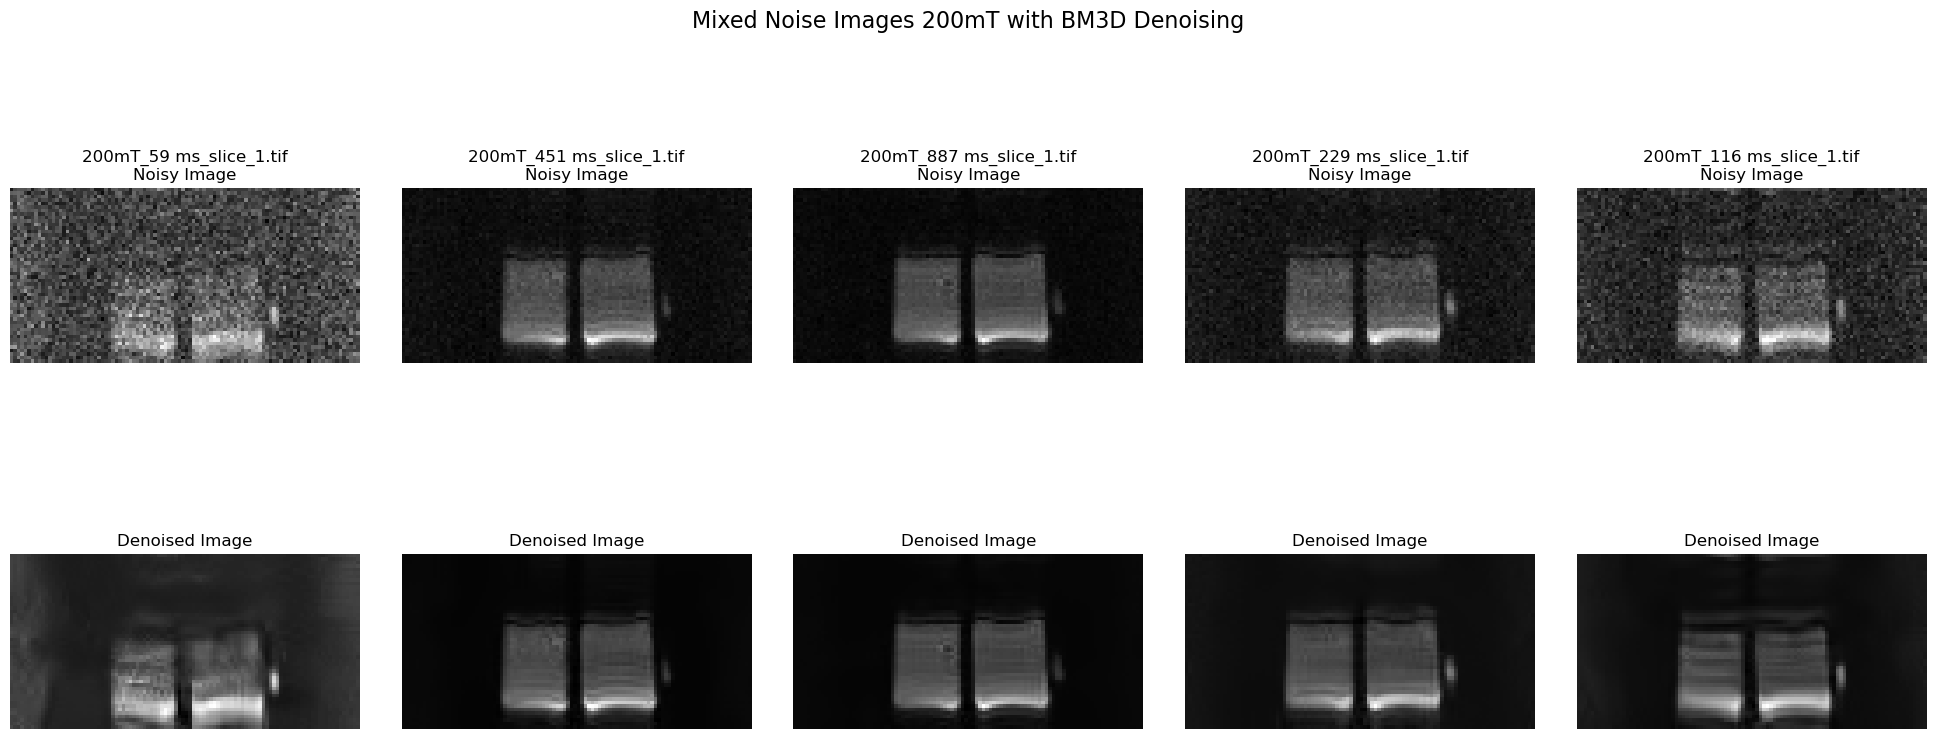

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
from skimage import io
import bm3d
import re


def extract_mT_value(filename):
    match = re.search(r'(\d+)_mT', filename)
    return int(match.group(1)) if match else 0

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    # Get a list of all .tif files in the directory
    file_list = [file for file in os.listdir(directory) if file.endswith('.tif')]

    # Sort file_list based on the mT values extracted from filenames
    file_list.sort(key=extract_mT_value)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        # Read the image
        image = io.imread(os.path.join(directory, filename))

        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] == 3:
            image_gray = rgb2gray(image)
        else:
            image_gray = image

        sigma_est = np.mean(estimate_sigma(image_gray))
        background_mask = create_background_mask(image_gray)

        # Apply BM3D Denoising
        denoised_image = bm3d.bm3d(image_gray, sigma_psd=sigma_est)
        

       
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray', interpolation='nearest')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray', interpolation='nearest')
        plt.title(f'Denoised Image')
        denoised_filename = f"denoised_{filename}.tiff"  # Create a unique filename outside imsave
        denoised_filepath = os.path.join(directory, denoised_filename)  # Construct full path
        plt.imsave(denoised_filepath, denoised_image, cmap='gray')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (len(file_list) - 1), len(file_list))
    x_tick_labels = [0, 2, 20] + [200] * (len(file_list) - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Mixed Noise Images 200mT with BM3D Denoising', fontsize=16, y=0.92)
    plt.show()


directory = '../TraditionalMethods/Experiments/PhantomData/200mT/'
denoise_medical_phantom(directory)


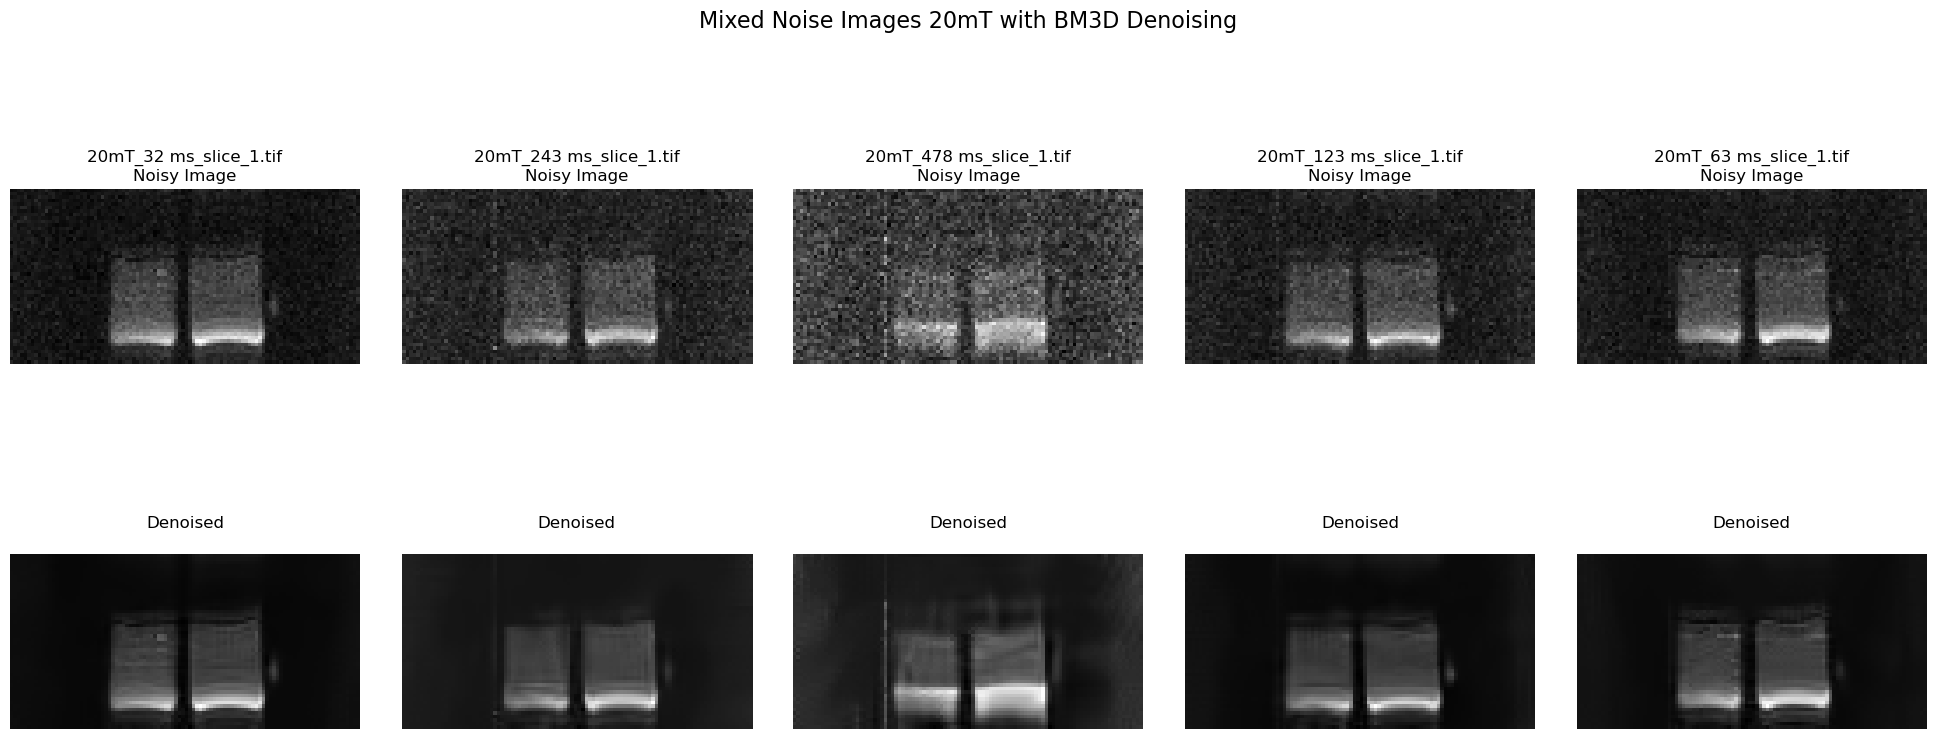

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
from skimage import io
import bm3d
import re



def extract_mT_value(filename):
    match = re.search(r'(\d+)_mT', filename)
    return int(match.group(1)) if match else 0

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    # Get a list of all .tif files in the directory
    file_list = [file for file in os.listdir(directory) if file.endswith('.tif')]

    # Sort file_list based on the mT values extracted from filenames
    file_list.sort(key=extract_mT_value)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        # Read the image
        image = io.imread(os.path.join(directory, filename))

        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] == 3:
            image_gray = rgb2gray(image)
        else:
            image_gray = image

        sigma_est = np.mean(estimate_sigma(image_gray))
        background_mask = create_background_mask(image_gray)

        # Apply BM3D Denoising
        denoised_image = bm3d.bm3d(image_gray, sigma_psd=sigma_est)
        

        # For denoised image, let's also calculate the standard deviation for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
        
        

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray', interpolation='nearest')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray', interpolation='nearest')
        plt.title(f'Denoised\n ')
        denoised_filename = f"denoised_{filename}.tiff"  # Create a unique filename outside imsave
        denoised_filepath = os.path.join(directory, denoised_filename)  # Construct full path
        plt.imsave(denoised_filepath, denoised_image, cmap='gray')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (len(file_list) - 1), len(file_list))
    x_tick_labels = [0, 2, 20] + [200] * (len(file_list) - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Mixed Noise Images 20mT with BM3D Denoising', fontsize=16, y=0.92)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/20mT/'
denoise_medical_phantom(directory)


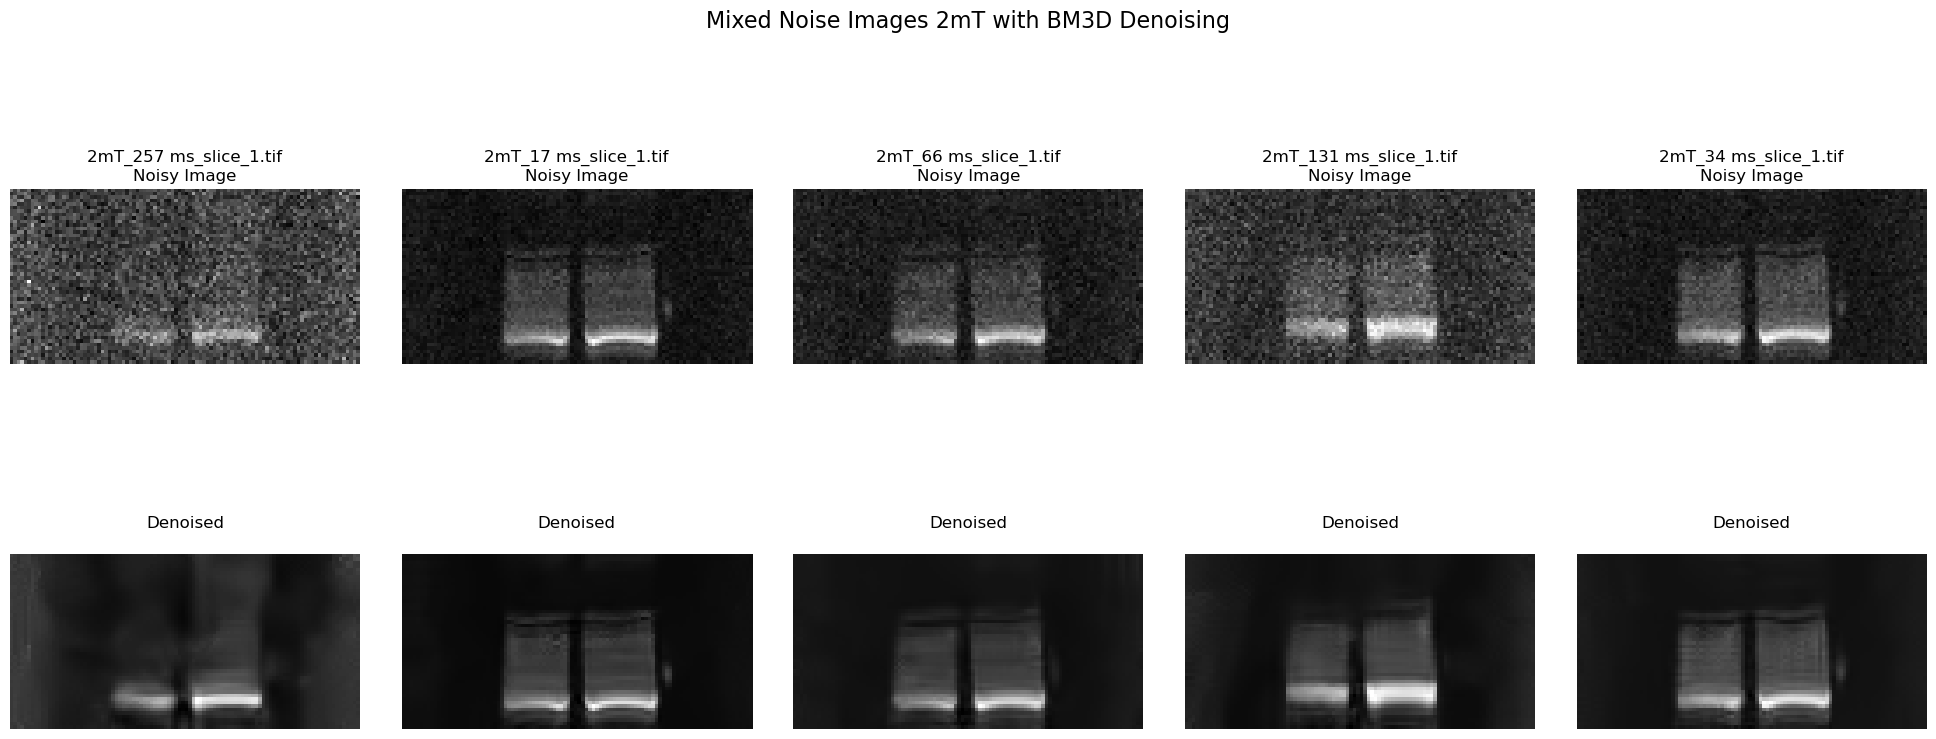

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
from skimage import io
import bm3d
import re



def extract_mT_value(filename):
    match = re.search(r'(\d+)_mT', filename)
    return int(match.group(1)) if match else 0

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    # Get a list of all .tif files in the directory
    file_list = [file for file in os.listdir(directory) if file.endswith('.tif')]

    # Sort file_list based on the mT values extracted from filenames
    file_list.sort(key=extract_mT_value)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        # Read the image
        image = io.imread(os.path.join(directory, filename))

        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] == 3:
            image_gray = rgb2gray(image)
        else:
            image_gray = image

        sigma_est = np.mean(estimate_sigma(image_gray))
        background_mask = create_background_mask(image_gray)

        # Apply BM3D Denoising
        denoised_image = bm3d.bm3d(image_gray, sigma_psd=sigma_est)
        

        # For denoised image, let's also calculate the standard deviation for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
       

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray', interpolation='nearest')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray', interpolation='nearest')
        plt.title(f'Denoised\n')
        denoised_filename = f"denoised_{filename}.tiff"  # Create a unique filename outside imsave
        denoised_filepath = os.path.join(directory, denoised_filename)  # Construct full path
        plt.imsave(denoised_filepath, denoised_image, cmap='gray')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (len(file_list) - 1), len(file_list))
    x_tick_labels = [0, 2, 20] + [200] * (len(file_list) - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Mixed Noise Images 2mT with BM3D Denoising', fontsize=16, y=0.92)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/2mT/'
denoise_medical_phantom(directory)


Spatial dimensions of 0mT_138 ms_slice_1.tif: (50, 100)
Spatial dimensions of 0mT_70 ms_slice_1.tif: (50, 100)
Spatial dimensions of 0mT_18 ms_slice_1.tif: (50, 100)
Spatial dimensions of 0mT_9 ms_slice_1.tif: (50, 100)
Spatial dimensions of 0mT_36 ms_slice_1.tif: (50, 100)


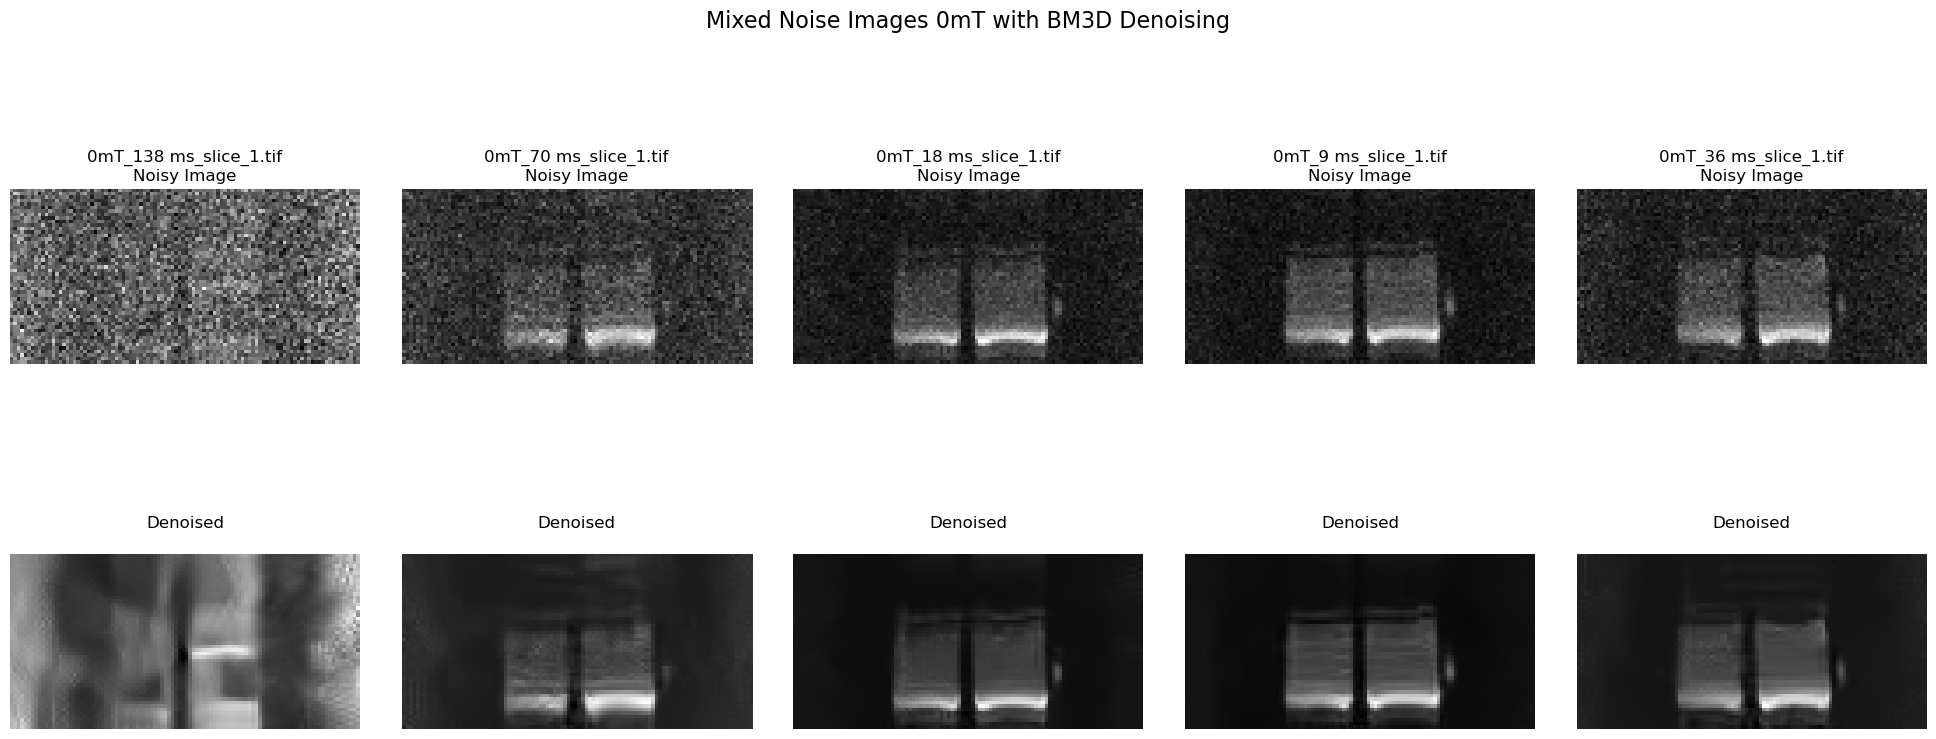

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
import os
from skimage import io
import bm3d
import re




def extract_mT_value(filename):
    match = re.search(r'(\d+)_mT', filename)
    return int(match.group(1)) if match else 0

def create_background_mask(image_gray):
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label
    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    # Get a list of all .tif files in the directory
    file_list = [file for file in os.listdir(directory) if file.endswith('.tif')]

    # Sort file_list based on the mT values extracted from filenames
    file_list.sort(key=extract_mT_value)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        # Read the image
        image = io.imread(os.path.join(directory, filename))

        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] == 3:
            image_gray = rgb2gray(image)
        else:
            image_gray = image

        sigma_est = np.mean(estimate_sigma(image_gray))
        background_mask = create_background_mask(image_gray)

        # Apply BM3D Denoising



        denoised_image = bm3d.bm3d(image_gray, sigma_psd=sigma_est)
        

        # For denoised image, let's also calculate the standard deviation for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
      

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray', interpolation='nearest')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray', interpolation='nearest')
        plt.title(f'Denoised\n')
        denoised_filename = f"denoised_{filename}.tiff"  # Create a unique filename outside imsave
        denoised_filepath = os.path.join(directory, denoised_filename)  # Construct full path
        plt.imsave(denoised_filepath, denoised_image, cmap='gray')
        # Print spatial dimensions of the image
        print(f"Spatial dimensions of {filename}: {image_gray.shape}")
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (len(file_list) - 1), len(file_list))
    x_tick_labels = [0, 2, 20] + [200] * (len(file_list) - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Mixed Noise Images 0mT with BM3D Denoising', fontsize=16, y=0.92)
    plt.show()
     

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/OmT'

denoise_medical_phantom(directory)

TIFF files found: ['denoised_0mTPhantom.tiff', '200mTPhantom.tif', 'denoised_200mTPhantom.tif', '0mTPhantom.tiff', '2mTPhantom.tiff', 'denoised_2mTPhantom.tiff', 'denoised_20mTPhantom.tiff', '20mTPhantom.tiff']
Denoised volume saved as denoised_denoised_0mTPhantom.tiff.
Denoised volume saved as denoised_200mTPhantom.tif.
Denoised volume saved as denoised_denoised_200mTPhantom.tif.
Denoised volume saved as denoised_0mTPhantom.tiff.
Denoised volume saved as denoised_2mTPhantom.tiff.
Denoised volume saved as denoised_denoised_2mTPhantom.tiff.
Denoised volume saved as denoised_denoised_20mTPhantom.tiff.
Denoised volume saved as denoised_20mTPhantom.tiff.


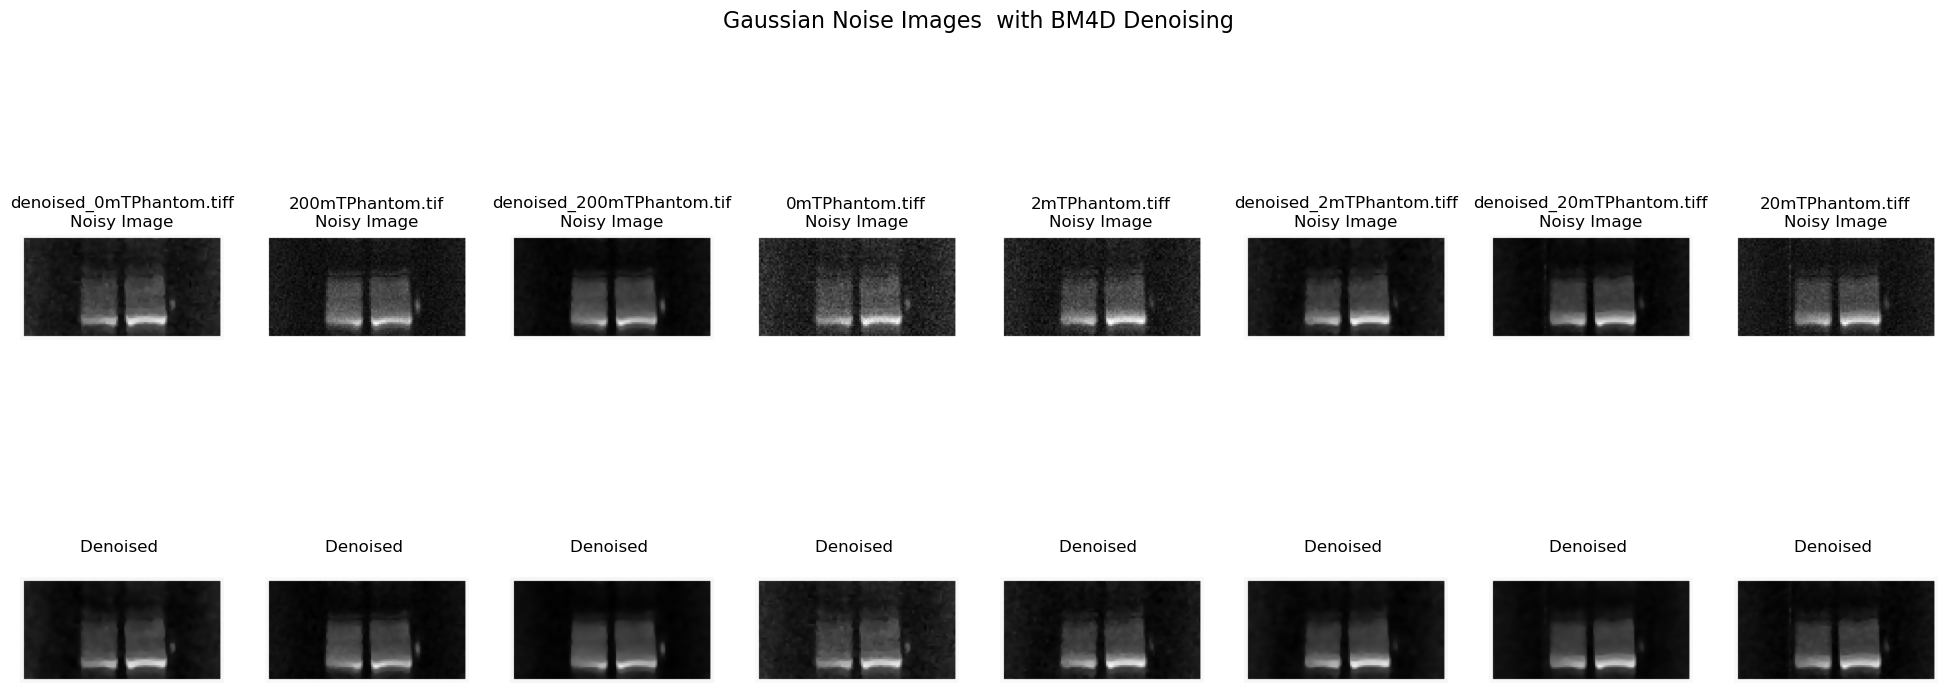

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage import io
import os
import bm4d


# Example of denoised_image array shape check and save
def save_image(denoised_image, denoised_filepath):
    # If denoised_image is 3D with a single channel, convert it to 2D
    if denoised_image.ndim == 3 and denoised_image.shape[-1] == 1:
        denoised_image = denoised_image.squeeze()  # Remove the single-channel dimension
    
    # Normalize to 0-1 range if not already
    denoised_image = denoised_image / denoised_image.max()
    
    plt.imsave(denoised_filepath, denoised_image, cmap='gray')
    print(f"Image saved to {denoised_filepath}")
def create_background_mask(image_gray):
    # Assumes image_gray is already a grayscale image
    thresh = threshold_otsu(image_gray)
    binary_image = image_gray <= thresh
    cleared_image = clear_border(binary_image)
    label_image = label(cleared_image)
    regions = regionprops(label_image)

    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    background_mask = label_image == background_label
    return background_mask

def denoise_medical_phantom(directory):
    file_list = [file for file in os.listdir(directory) if file.lower().endswith(('.tif', '.tiff'))]
    print("TIFF files found:", file_list)

    plt.figure(figsize=(20, 10))

    for i, filename in enumerate(file_list):
        image = io.imread(os.path.join(directory, filename))
        
        # Convert to grayscale if it's a multichannel image
        if image.ndim == 3 and image.shape[2] in [3, 4]:
            image = rgba2rgb(image) if image.shape[2] == 4 else image
            image_gray = rgb2gray(image)
        else:
            image_gray = image
        
        # Create a background mask for noise estimation
        background_mask = create_background_mask(image_gray)
        
        # Use the background mask to isolate background pixels for noise estimation
        background_pixels = image_gray[background_mask]
       
        
        # Apply BM4D Denoising using the estimated noise level from the background
        denoised_image = bm4d.bm4d(image_gray, sigma_psd=30/255, stage_arg=bm4d.BM4DStages.HARD_THRESHOLDING)
        
        # Calculate the standard deviation of the denoised image for comparison
        std_deviation_denoised = np.std(denoised_image[background_mask])
        denoised_filename = f"denoised_{filename}"
        denoised_filepath = os.path.join(directory, denoised_filename)
        io.imsave(denoised_filepath, denoised_image.astype(np.float32))
        print(f"Denoised volume saved as {denoised_filename}.")
        

        plt.subplot(2, len(file_list), i + 1)
        plt.imshow(image_gray, cmap='gray')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, len(file_list), i + len(file_list) + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised \n')

        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.arange(len(file_list)) + 0.5  # +0.5 to center ticks if needed
    plt.xticks(x_ticks_positions, [str(x) for x in range(1, len(file_list) + 1)])

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Gaussian Noise Images  with BM4D Denoising', fontsize=16, y=0.92)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/3Dstackedupimages'
denoise_medical_phantom(directory)
